___

# M915 - Συστήματα Κατανόησης και Παραγωγής Κειμένου <br> <span style="font-size:6mm;"> Assignment 2 </span> <br><br> <span style="font-size:5mm;"> Kylafi Christina-Theano </span> <br> <span style="font-size:4mm;"> LT1200012 </span>
---
---

## Imports
---

In [2]:
# import Python libraries

# essentials
import os
import random
from random import sample
import numpy as np
from numpy import mean, std
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from collections import Counter
import re, string, unicodedata
import pickle 
from datetime import datetime
import pytz
from itertools import cycle
from scipy import interp 
import time
import copy
import json
import csv
from ast import literal_eval

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

# SKLEARN
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, OneHotEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, log_loss, plot_confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import utils
from sklearn.svm import SVC

# NLTK
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

!pip install datasets
from datasets import load_metric

# BERT
# !pip install transformers
# !pip install pytorch-pretrained-bert

import transformers
from transformers.data.processors.squad import SquadV2Processor
from transformers.data import squad_convert_examples_to_features
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel, BertForPreTraining, BertTokenizerFast, AdamW, BertForQuestionAnswering, DistilBertTokenizer, DistilBertForQuestionAnswering, DistilBertTokenizerFast, DistilBertModel
from torch.utils.data import DataLoader
from transformers import AdamW
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

import warnings

# MORE INSTALLATIONS & IMPORTS
# !pip install yellowbrick
# !pip install advertools
# !pip install vaderSentiment
# !pip install ekphrasis
# !pip install tweet-preprocessor

from wordcloud import WordCloud
# import advertools as adv
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from ekphrasis.classes.segmenter import Segmenter
# import preprocessor as p
import multiprocessing
from shutil import copy
import seaborn as sns
from gensim.models import Word2Vec
from IPython.display import Image, FileLink, FileLinks, clear_output
from ast import literal_eval
from tqdm.notebook import tqdm
# clear_output()

print("\nImports Done !\n")

# Device settings
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Working on {device}")



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Imports Done !

Working on cuda


## Functions
---

In [97]:
# Functions

# convert squad dataset to dataframe by extracting the necessary info
def squad_df(file_path, record_path=['data','paragraphs','qas','answers']):
    file = json.loads(open(file_path).read())
    
    # parsing different level's in the json file
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file,record_path[:-2])
    
    # combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id','context','question','answers']].set_index('id').reset_index()
    # keep the text sequence number for later
    data['context_id'] = data['context'].factorize()[0]
    return data


# Add answer ending index
def add_ans_ind(qna_df):
    texts = qna_df["context"]
    answers = qna_df["answers"]
    for row,(text,answers) in enumerate(zip(texts,answers)):
        for a_num,a in enumerate(answers):
            a_text = a["text"]
            a_start = a["answer_start"]
            a_end = a_start
            
            a_end = int(a_start+len(a_text))
            if text[a_start:a_end] == a_text:
                qna_df.loc[row,"answers"][a_num]["answer_end"]=a_end
            else:
                if a_start==0:
                    continue
                else:
                    if a_start==1:
                        if text[a_start-1:a_end-1] == a_text:
                            qna_df.loc[row,"answers"][a_num]["answer_start"]= a_start - 1
                            qna_df.loc[row,"answers"][a_num]["answer_end"]= a_end - 1

                    else:
                        if text[a_start-2:a_end-2] == a_text:
                            qna_df.loc[row,"answers"][a_num]["answer_start"]= a_start - 2
                            qna_df.loc[row,"answers"][a_num]["answer_end"]= a_end - 2

    return qna_df


# add the starting-ending positions of answers (token-wise)
def add_token_positions(encodings, texts, starts, ends):
    # initialize lists to contain the token indices of answer start/end
    start_pos = []
    end_pos = []
    unanswerable_pos = tokenizer.model_max_length
    for i,(text,start,end) in enumerate( zip(texts,starts,ends) ):
        # unanswerable questions
        if start==end==len(text):
            start_pos.append(unanswerable_pos)
            end_pos.append(unanswerable_pos)
            continue
        else:
            start_pos.append(encodings.char_to_token(i, start))
            end_pos.append(encodings.char_to_token(i, end))
            if start_pos[-1] is None:
                start_pos[-1] = unanswerable_pos
                end_pos[-1] = unanswerable_pos
                continue
           
            shift = 1
            while end_pos[-1] is None and end-shift>start:
                end_pos[-1] = encodings.char_to_token(i, end - shift)
                shift += 1
            if end_pos[-1] is None:
                start_pos[-1] = unanswerable_pos
                end_pos[-1] = unanswerable_pos

    encodings.update({'start_positions': start_pos, 'end_positions': end_pos})

# apply function to our data
# add_token_positions(dev_encodings, list(qna_dev_df['AnswerStart']), list(qna_dev_df['AnswerEnd']))


def save_json_evalsquad1(total_preds,filepath="preds.json", dev_set="/content/dev-v2.0.json"):
    with open(filepath, "w") as outfile:
        json.dump(ast.literal_eval(json.dumps(total_preds)), outfile)
    
#     !python3 /content/evaluate-v2.0.py {dev_set} {filepath}
    !python3 /kaggle/input/bert-code/bert/evaluate.py {dev_set} {filepath} 

    
def get_prediction(qid,total_preds):
    return total_preds[qid]

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch if ch not in exclude else " " for ch in text)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)



def get_gold_answers(qid,id_to_answers):
    
    gold_answers = [answer["text"] for answer in id_to_answers[qid] if answer["text"]]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
    
    return gold_answers

def evalEMandF1_squad1(dev_df,total_preds,model_dir):
    global id_to_answers
    questions = [  q for q in dev_df["question"].values  ]
    id_s = [ i for i in dev_df["id"].values ]
    answer_s = [ ans for ans in dev_df["answers"].values ]
    
#     id_to_answers = {k:v for k,v in zip(id_s,answer_s)}
    em_score = []
    f1_score = []

#   logfile for predictions and true answers
    logfile_name = "model_preds.txt"
    logfile_path = os.path.join( os.path.join(model_dir),logfile_name)
    logfile = open(logfile_path, "w", encoding="utf-8")
    logfile.write("Best Model Question Predictions on Dev Set\n")
    for num,(qid,quest) in enumerate(zip(id_s,questions)):
        prediction = get_prediction(qid,total_preds)
        true_answers = get_gold_answers(qid,id_to_answers)

        em_score.append(max((compute_exact_match(prediction, answer)) for answer in true_answers))
        f1_score.append(max((compute_f1(prediction, answer)) for answer in true_answers))
        
        log_str = f"\n\n{num+1}. Question: {quest}\nTrue Answer(s): {true_answers}\nPrediction(s): {prediction}\nEM: {bool(int(em_score[-1]))}\nF1: {f1_score[-1]*100:.2f}%"
        logfile.write(log_str)
    
    logfile.close()
    
    em = sum(em_score)/len(id_s)*100
    f1_mean = sum(f1_score)/len(id_s)*100
    f1_max = max(f1_score)*100
    score_str = f"Dev Set Scores -- \tEM: {em:.2f}% \tF1 (mean): {f1_mean:.2f}% \tF1 (max): {f1_max:.2f}%\n"
    print(score_str)
    return em,f1_mean,f1_max,score_str


def total_preds_list(model,dev_dataset,device,dev_df):
    global id_to_answers
    model.to(device)
    model.eval()
    # initialize list to store epoch accuracies

    total_preds = {}
    acc = []
    gtruth = {}
    predictions = {}

    batch_size=64
    val_loader = DataLoader(dev_dataset, batch_size=batch_size)
    id_list = [ i for i in dev_df["id"].values ]
    batch_sizes= [ len(val_b["input_ids"]) for val_b in val_loader]
    batches=len(val_loader)
    id_loader = [ id_list[i*batch_size:i*batch_size+batch_size] for i in range(batches-1) ]
    id_loader.append( id_list[- batch_sizes[-1] :] )
#     print(id_loader, batch_sizes, batches)

    # create a dictionary to link question id's with answers
    questions = [  q for q in dev_df["question"].values  ]
#     id_list = [ i for i in dev_df["id"].values ]
    answer_s = [ ans for ans in dev_df["answers"].values ]
    
    loss_dev = 0
    loop_dev = tqdm(val_loader,leave=True)
    for batch,ids in zip(val_loader, id_loader):
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # we will use true positions for accuracy calc
    #         start_true = batch['start_positions'].to(device)
    #         end_true = batch['end_positions'].to(device)
            qid = ids
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
#             loss = outputs[0]
#             loss_dev += loss.item()
    #         print(outputs['start_logits'])
            # pull prediction tensors out and argmax to get predicted tokens
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)

    #         ans_pred_list = [ (question_id,p) for question_id,p in zip(qid,preds) ]
            preds = [ tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[num][start_pred[num]:end_pred[num]])) for num in range(len(qid)) ]
            total_preds.update({ q:pred for q,pred in zip(qid,preds) })
            
            loop_dev.update(1)

    return total_preds


def log_model(logfile,datetime_info,model,model_name,loss_func,optimizer,batch_size,normalization,max_s_len,pretrained):
    separator = "".join([ "_" for i in range(50) ])
    logstring = ""

    # logstring+= f"\n\n\n\n{separator}\n{separator}\n\n"
    logstring+= f"{datetime_info} - {model_name}\n\n"
    logstring+= f"Features: {model.embedding.embedding_dim}\n"
    logstring+= f"Max Sentence length: {max_s_len}\n"
    logstring+= f"Pretrained Embeddings: {pretrained}\n"
    logstring+= f"Normalization: {normalization}\n"
    # logstring+= f"Epochs: {epochs}\n"
    logstring+= f"Batch size: {batch_size}\n"
    logstring+= f"Optimizer: {optimizer}\n"
    logstring+= f"Loss function: {loss_func}"
    if type(loss_func) == torch.nn.CrossEntropyLoss:
        logstring+= f", weight: {loss_func.weight}\n"
    else :
        logstring+= "\n"
        logstring+= f"Layers: {model}\n\n"
        logstring+= f"{separator}\n\n"

    logfile.write(logstring)


def log_score(logfile,epoch,model,score_str):
    separator = "".join([ "_" for i in range(50) ])
    logstring = ""

    logstring+= f"\n\n\n> Epoch:{epoch}\n"
    logstring+= score_str


    logfile.write(logstring)


# Logfiles
def get_file_ptr(drive_path,model_name):
    tz = pytz.timezone('Europe/Athens')
    datetime_info = f"{datetime.now(tz):%d%m%y_%H%M}"

    logfile_name = f"{model_name}__{datetime_info}.txt"
    model_logfile_dir_path = os.path.join(drive_path, f"Results/Logfiles/{logfile_name[:-4]}") 
    if not os.path.exists(model_logfile_dir_path):
        os.makedirs(model_logfile_dir_path)  

    logfile_path = os.path.join( os.path.join(model_logfile_dir_path),logfile_name)
    logfile = open(logfile_path, "w", encoding="utf-8")

    return logfile, datetime_info, model_logfile_dir_path, logfile_path


def log_model_bert(logfile,datetime_info,model_name,optimizer,batch_size,max_s_len,train_len,val_len):
    separator = "".join([ "_" for i in range(50) ])
    logstring = ""

    # logstring+= f"\n\n\n\n{separator}\n{separator}\n\n"
    logstring+= f"{datetime_info} - {model_name}\n\n"
    logstring+= f"Max Sentence length: {max_s_len}\n"
    logstring+= f"Batch size: {batch_size}\n"
    logstring+= f"Optimizer: {optimizer}\n"
    logstring+= f"Training Data: {train_len}\n"
    logstring+= f"Validation Data: {val_len}\n"
    #   logstring+= f"Layers: {model}\n\n"
    logstring+= f"{separator}\n\n"

    logfile.write(logstring)
    
  
def preprocess_function(examples, tokenizer):
    questions = [ q.strip() for q in list(examples["question"])]
    inputs = tokenizer(
        questions,
        list(examples["context"]),
        max_length=tokenizer.model_max_length,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length")

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"].values
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        if type(answers[i])==type(str):
            answer = eval(answers[i][0])
        else:
            answer = answers[i][0]
        start_char = answer["answer_start"]
        end_char = start_char + len(answer["text"])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

def answer_a_question(question,text,tokenizer,model):
    model.to(device)
    model.eval()
    
    
    model_in=tokenizer.encode_plus(text, question, max_length=tokenizer.model_max_length, truncation="only_first", padding='max_length', return_tensors='pt')
    in_ids = model_in["input_ids"].to(device)
    mask = model_in["attention_mask"].to(device)
    
    outputs = model(in_ids, attention_mask=mask)
    start_pred = torch.argmax(outputs['start_logits'], dim=1).item()
    end_pred = torch.argmax(outputs['end_logits'], dim=1).item()
    
    text_ids= model_in["input_ids"][0]
    text_tokens=tokenizer.convert_ids_to_tokens(text_ids)

    tokens = tokenizer.convert_ids_to_tokens(text_ids[start_pred:end_pred+1])
    answer = tokenizer.convert_tokens_to_string(tokens)
    answer = normalize_text(answer).capitalize()
    
#     print(f"\nText: {text}\nQuestion: {question}\n\nPredicted answer: {answer}\n")

    return answer


# Data Visualization
def data_stats(df, data_type, N):
    plt.clf()
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    tokenizer.model_max_length=N
    enc = tokenizer(list(df['context']), truncation=True, max_length=tokenizer.model_max_length )
    lens=[ len(i_id) for i_id in enc["input_ids"] ]
    print(max(lens))
    plt.figure(figsize=(18,12))
    plt.grid(True)
    plt.title(f"{data_type} Set Cumulative Sum")
    plt.hist(lens)
    plt.savefig(os.path.join(results_path,f"{data_type}_max_lens_Csum_maxLen{N}.png"),dpi=300)
    plt.show()

    return lens,enc

def bar_plotting_lens(lens, data_type, val_to_show, N):
    plt.clf()
    lens_df=pd.DataFrame(lens)
    len_desc = [ len for len in lens_df[0].value_counts().index[:val_to_show].tolist() ]
    len_freq = [ freq for freq in lens_df[0].value_counts().tolist( )[:val_to_show] ]
    fig = plt.figure(figsize =(48, 6))
    bar_plot = plt.bar(len_desc, len_freq)
    max_freq_ind = len_freq.index(max(len_freq))
    bar_plot[max_freq_ind].set_color('m')
    plt.xticks(len_desc)
    plt.xlabel('Length')
    plt.ylabel('Num of Texts')
    plt.title(f"{data_type} set context length")
    plt.grid(True)
    # show plot
    plt.savefig(os.path.join(results_path,f"{data_type}_max_lens_maxLen{N}.png"),dpi=300)
    plt.show()
    return len_desc[max_freq_ind]

def perc_Csum(lens, data_type):
    len_vals=[50,100,150,200,256,300,512, max(lens)+1]
    print(f"\nPercentage of {data_type} set context under:")
    for L in len_vals:
        # plot cumulative summary and percentage of samples with context under length L
         print(f"{L} -> {sum([i<L for i in lens])/len(lens)*100:.2f}%")
    
def data_vis_unanswerable(df, encodings):
#     in_ids = [ id_list[:N] for id_list in encodings["input_ids"]  ]
#     encodings.update( {"input_ids": in_ids} )
    df["start"] = [ ans[0]["answer_start"] for ans in df["answers"].values ]
    df["start_token_id"] = [ encodings.char_to_token(i, start) for  i, start in enumerate(df["start"].values) ] 
#     df["in_ids"] = [id_list for id_list in encodings["input_ids"]]
    return df

# pr_list = add_ans_ind(qna_train_df_quac)
# pr_list = add_ans_ind(qna_dev_df_quac)

## SQuADv1.1 Dataset
---

#### Steps:
1. Add data 
2. Search for "bert-code" (https://www.kaggle.com/datasets/rndmnub/bert-code)

or

1. Save "train-v1.1.json" & "dev-v1.1.json" 
2. Change the "squad_train_path" & "squad_dev_path" variables below

In [4]:
# directories' paths
squad_train_path = "/kaggle/input/bert-code/bert/train-v1.1.json"
squad_dev_path = "/kaggle/input/bert-code/bert/dev-v1.1.json"
train_df = squad_df(squad_train_path)
dev_df = squad_df(squad_dev_path)

# decrease train dataset for quicker training process
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# train_df = train_df[: int(train_df.shape[0]/2)]
# print(train_df.shape)

# eval_v1_path = "/kaggle/input/bert-code/bert/evaluate.py"
# eval_v2_path = "/kaggle/input/httpsgithubcomsomiltgbert/evaluate-v2.0.py"


In [5]:
# results directory
results_path = "/kaggle/working/results" #change it if not run in Kaggle environment
if not os.path.exists(results_path):
    os.makedirs(results_path)

## Data Visualization
---

In [72]:
train_df["start_token_id"]

0        15.0
1        67.0
2        27.0
3         NaN
4        41.0
         ... 
87721    43.0
87722    79.0
87723    97.0
87724    36.0
87725     1.0
Name: start_token_id, Length: 87726, dtype: float64

50


<Figure size 432x288 with 0 Axes>

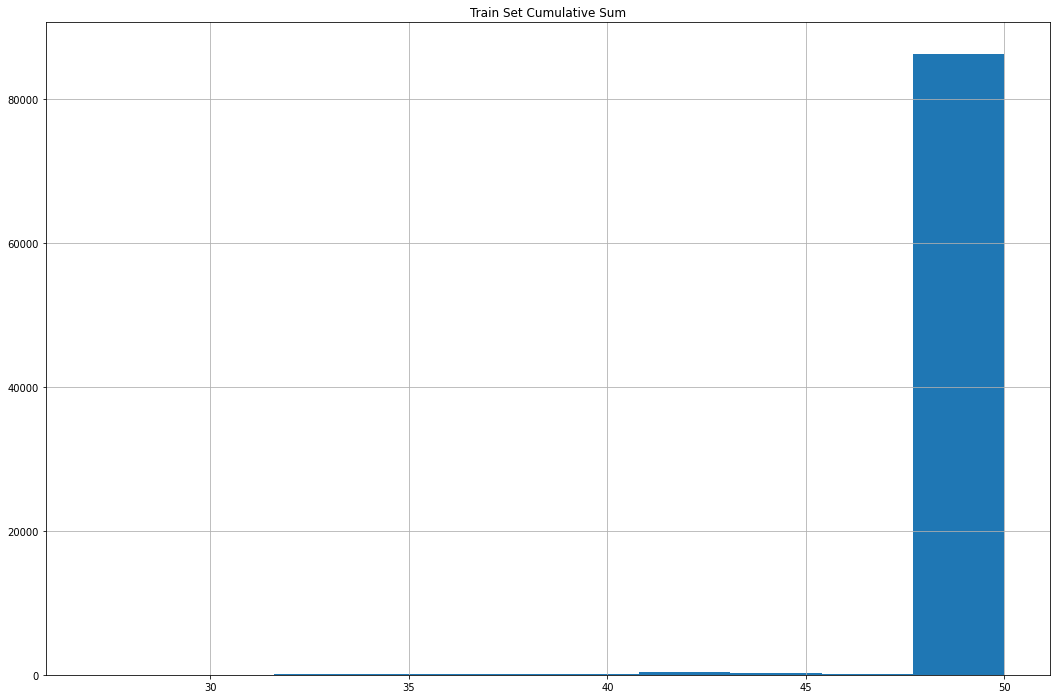

<Figure size 432x288 with 0 Axes>

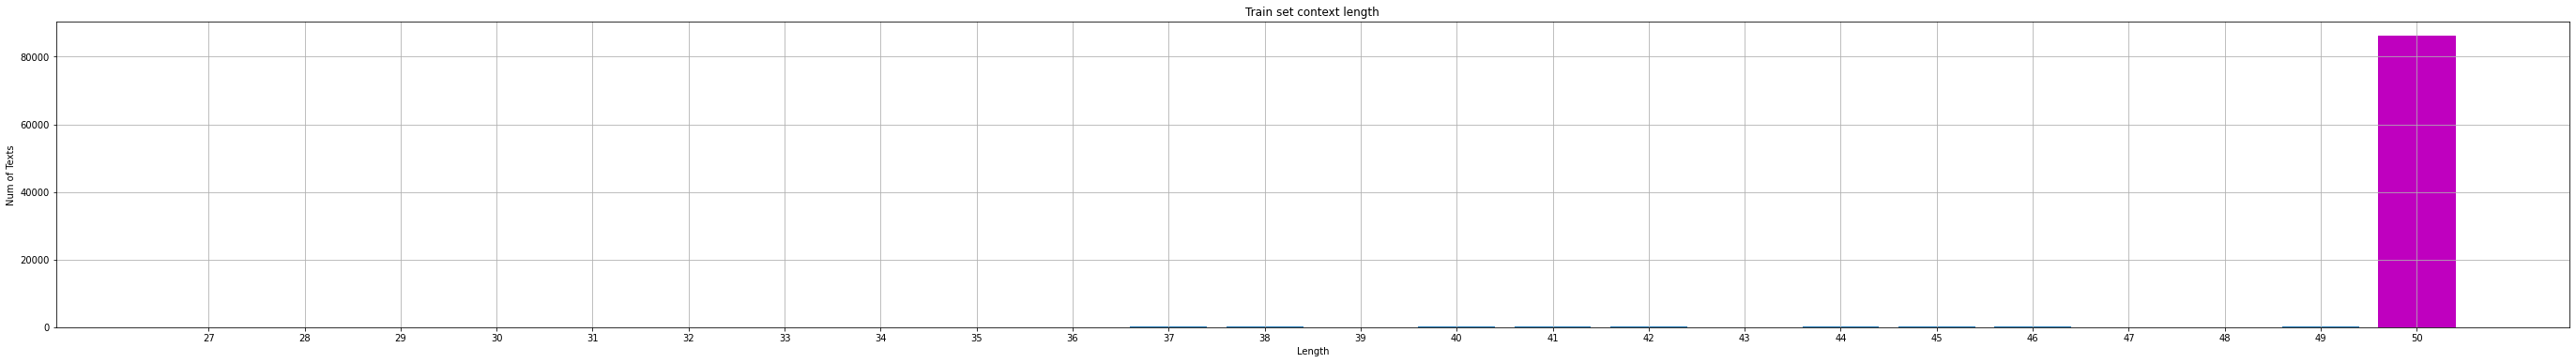


Answerable TRAIN questions for MaxLen 50: 54.01
50


<Figure size 432x288 with 0 Axes>

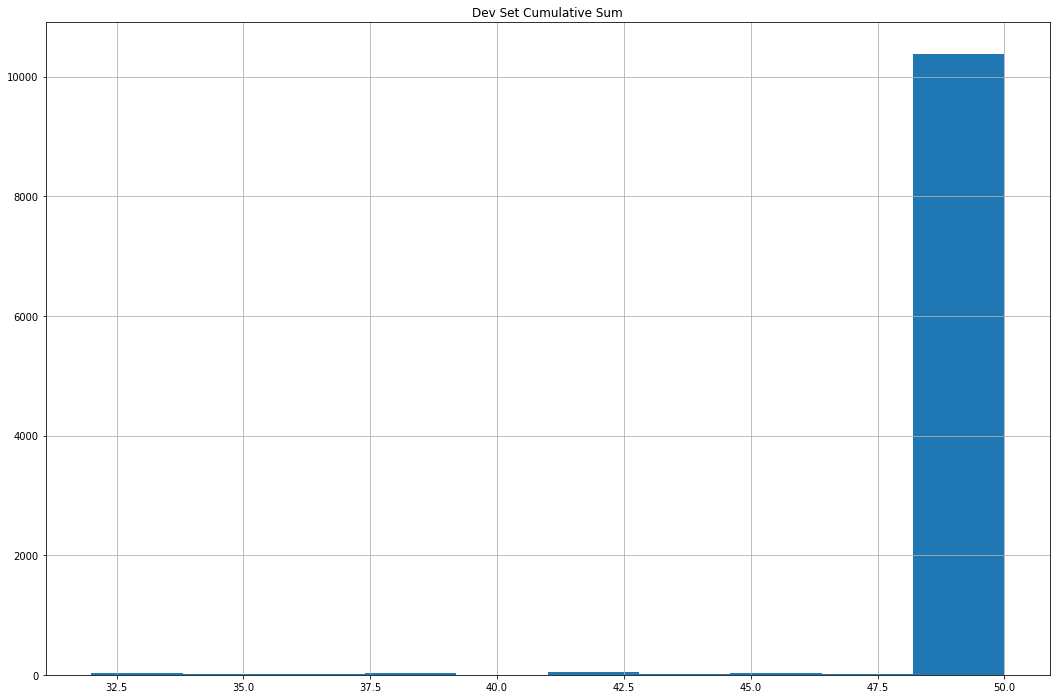

<Figure size 432x288 with 0 Axes>

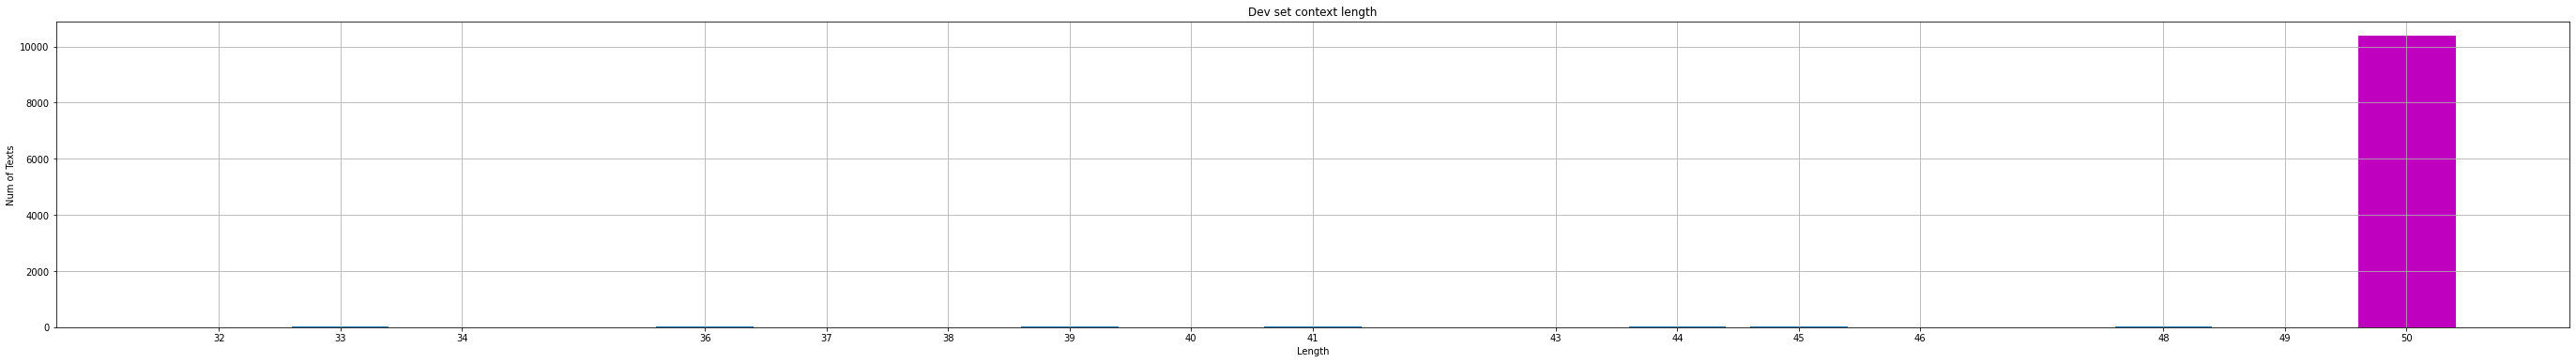


Answerable DEV questions for MaxLen 50: 54.56
100


<Figure size 432x288 with 0 Axes>

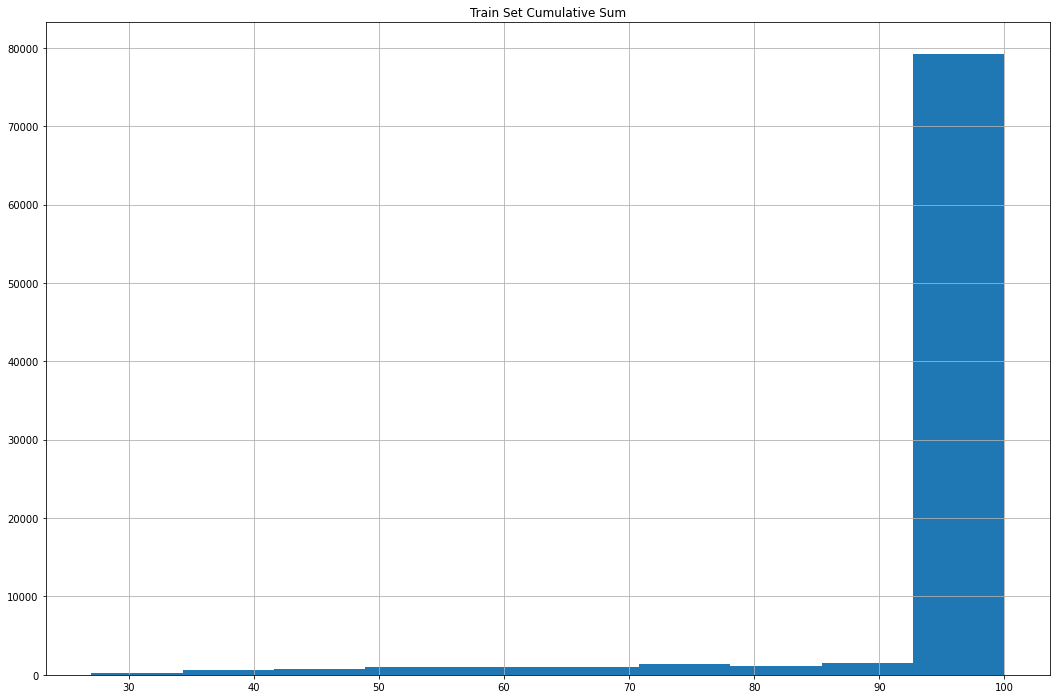

<Figure size 432x288 with 0 Axes>

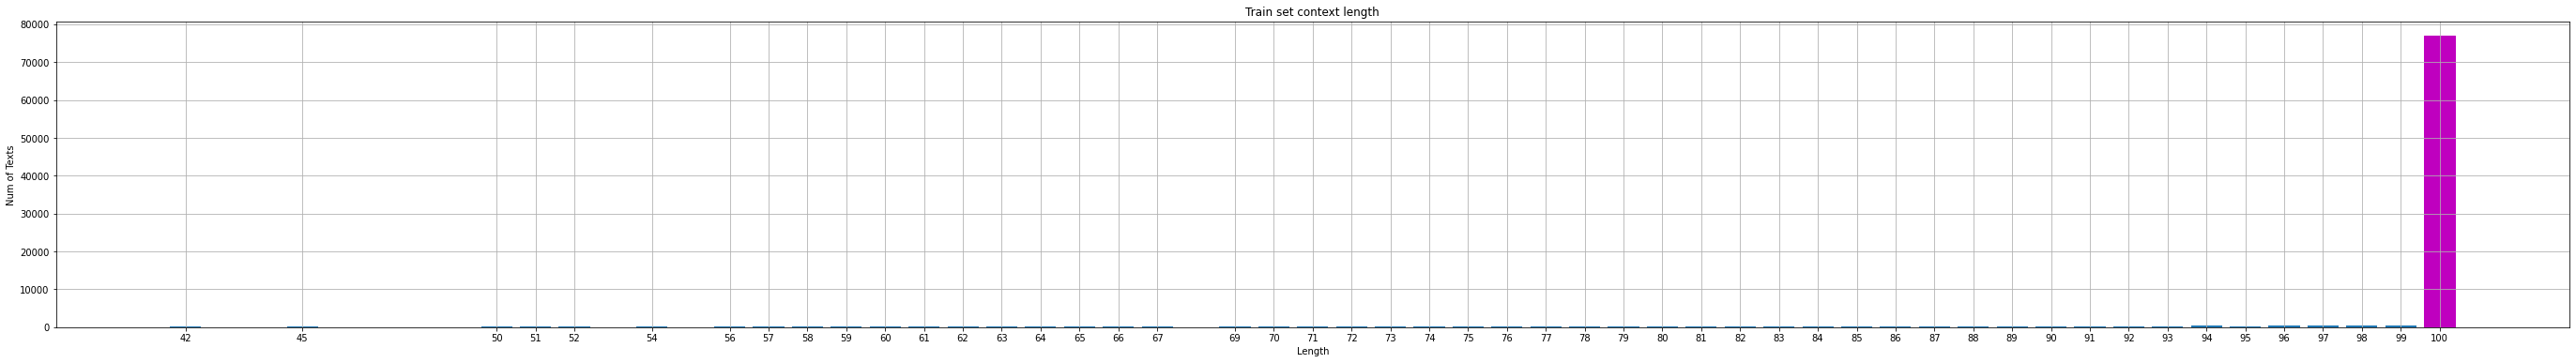


Answerable TRAIN questions for MaxLen 100: 23.97
100


<Figure size 432x288 with 0 Axes>

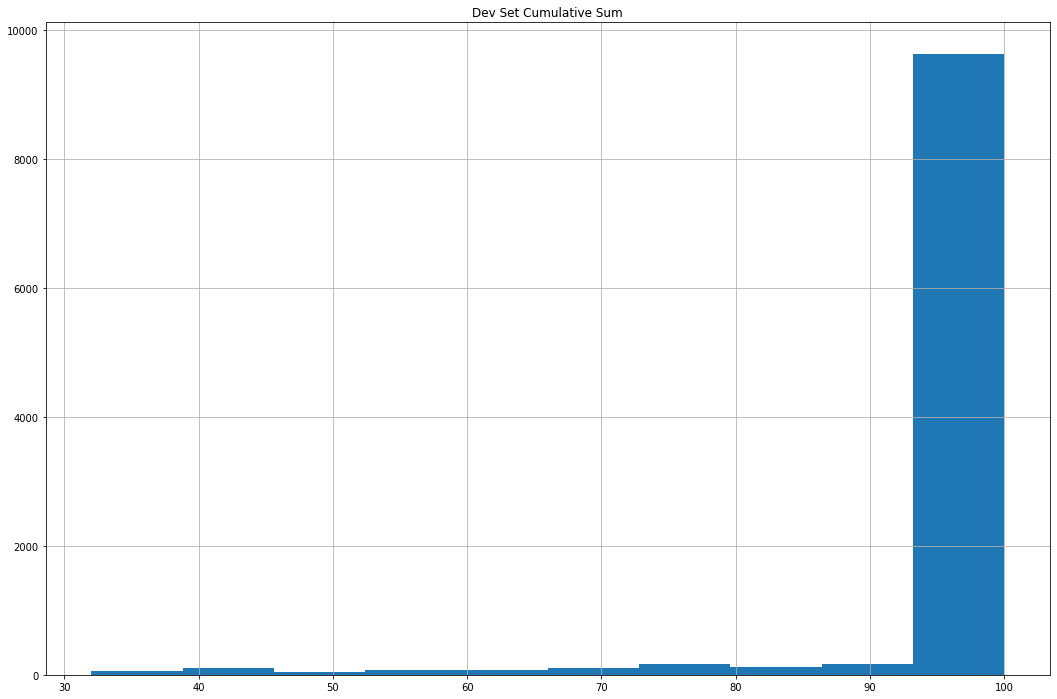

<Figure size 432x288 with 0 Axes>

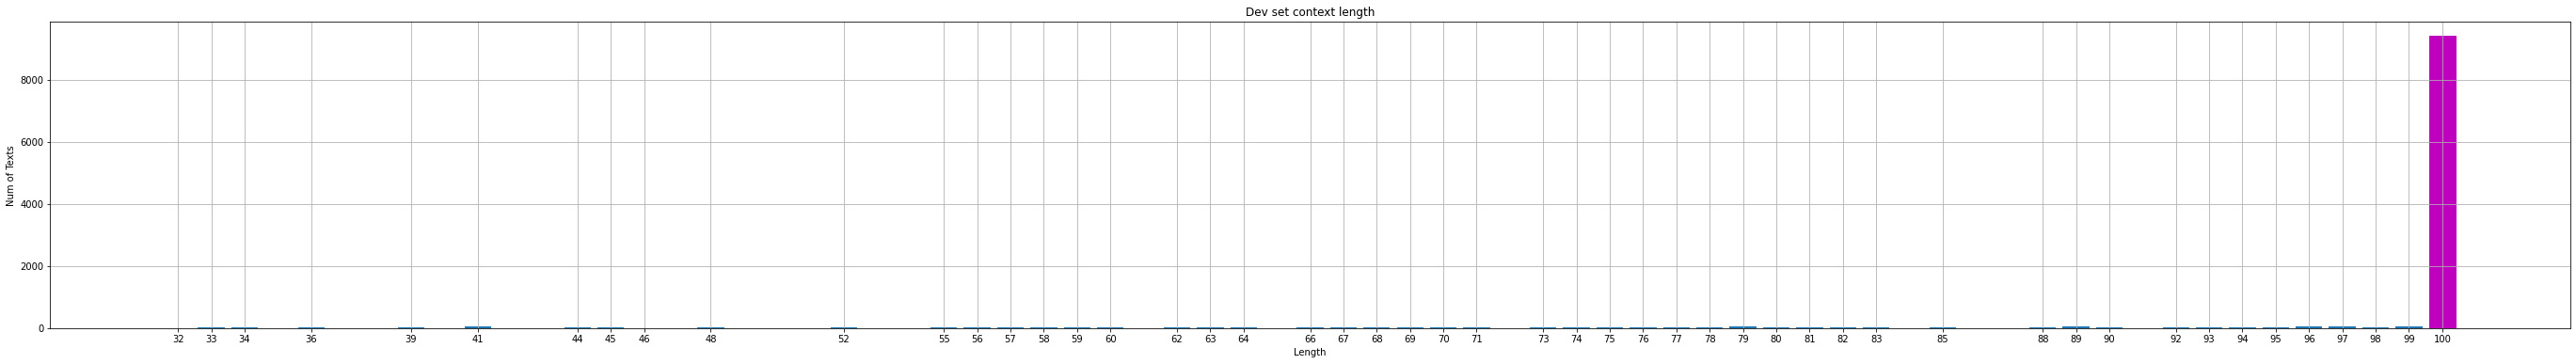


Answerable DEV questions for MaxLen 100: 24.72
150


<Figure size 432x288 with 0 Axes>

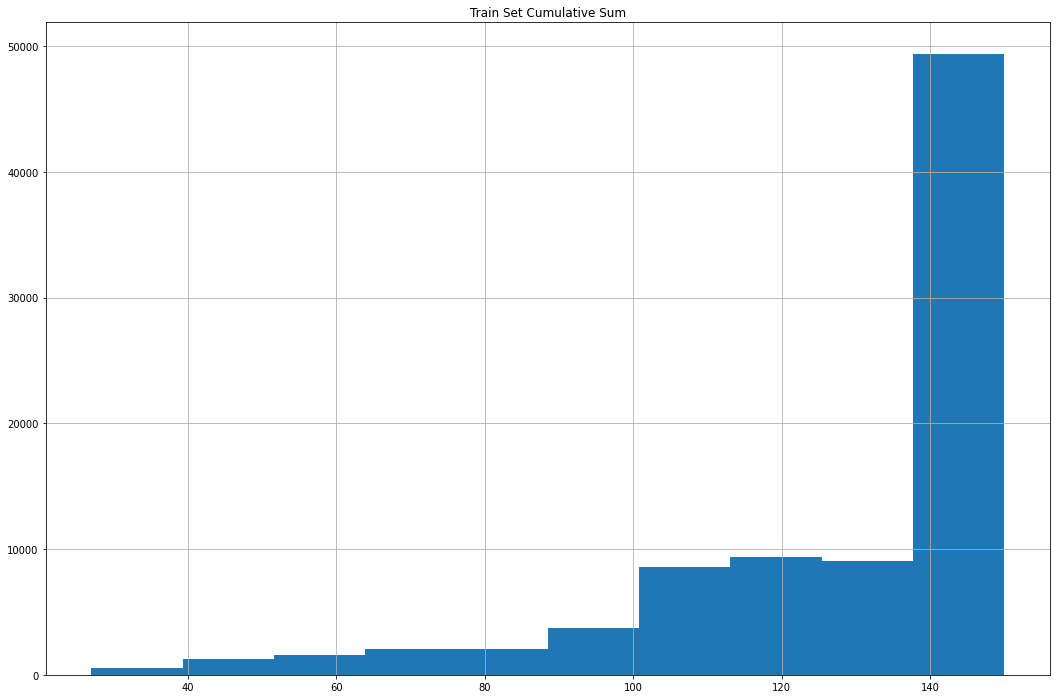

<Figure size 432x288 with 0 Axes>

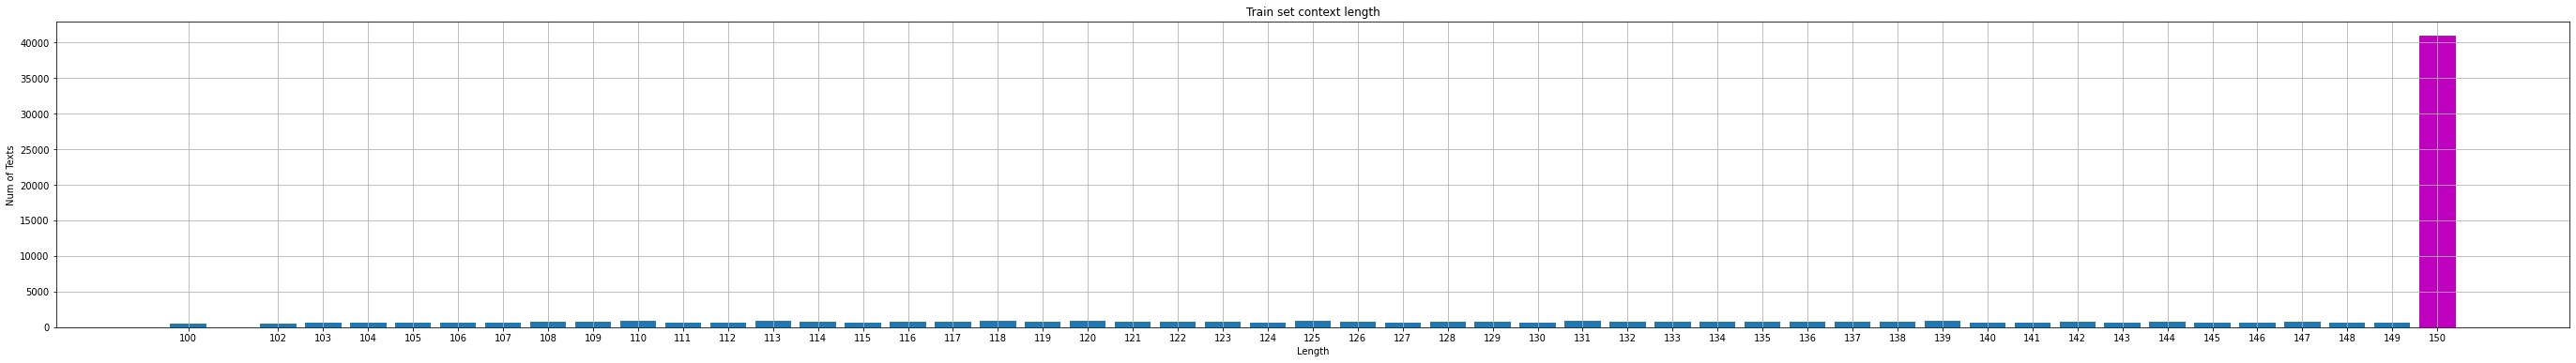


Answerable TRAIN questions for MaxLen 150: 8.08
150


<Figure size 432x288 with 0 Axes>

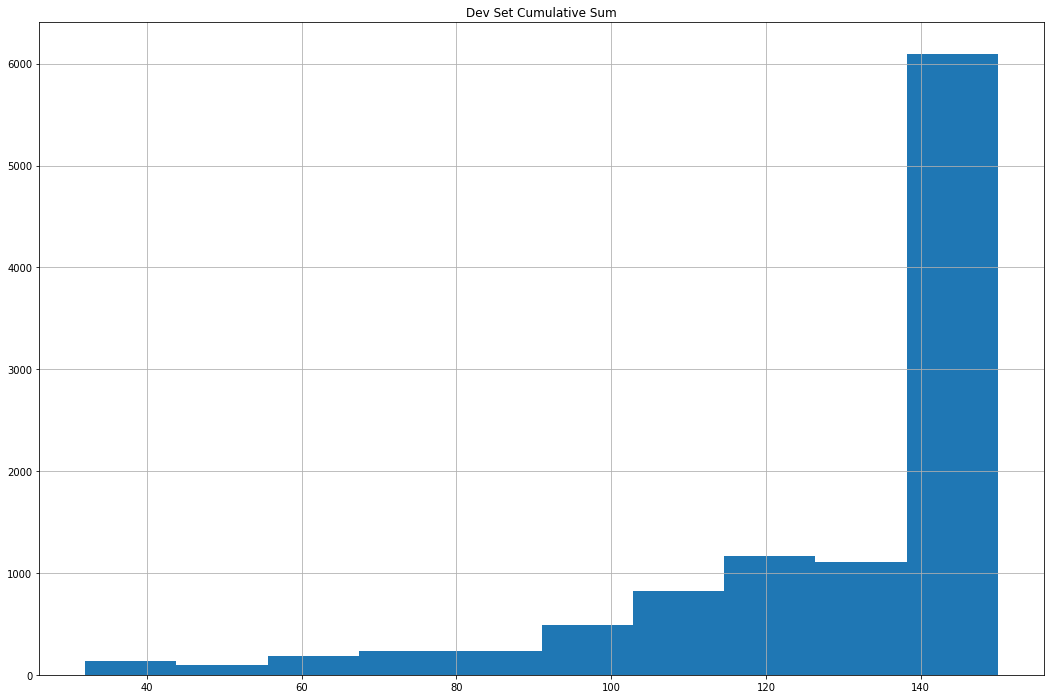

<Figure size 432x288 with 0 Axes>

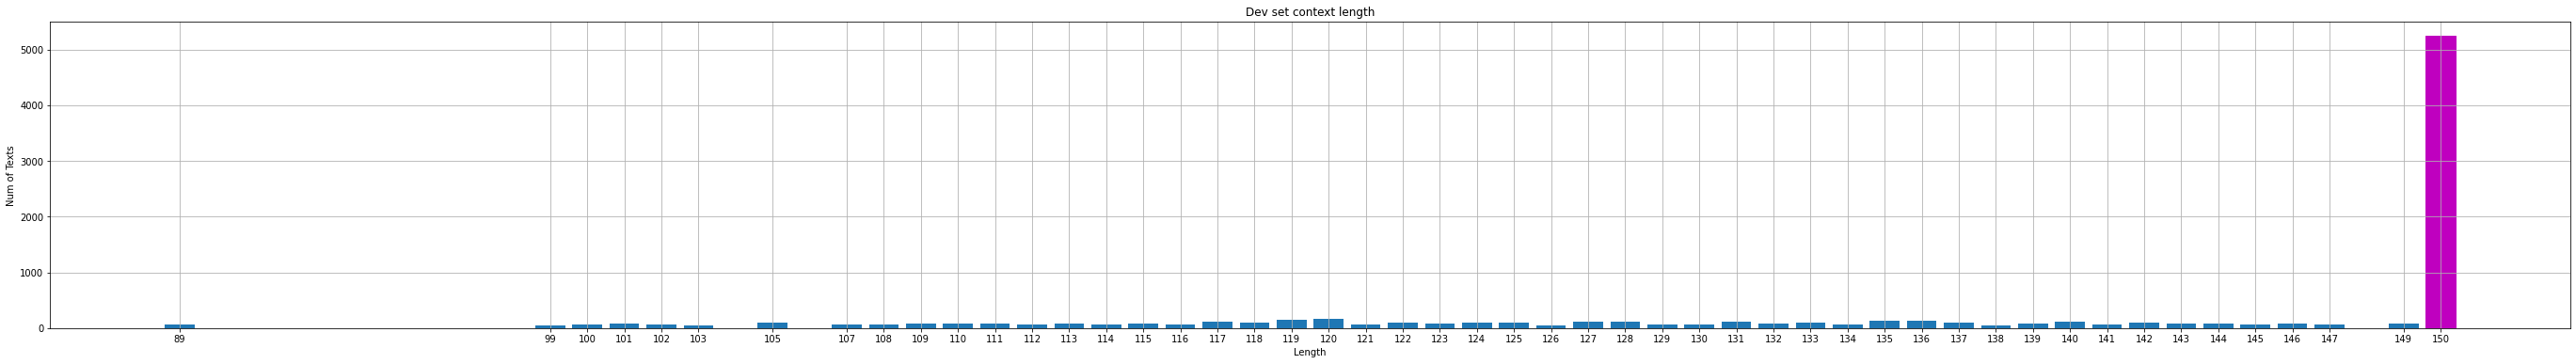


Answerable DEV questions for MaxLen 150: 8.52
200


<Figure size 432x288 with 0 Axes>

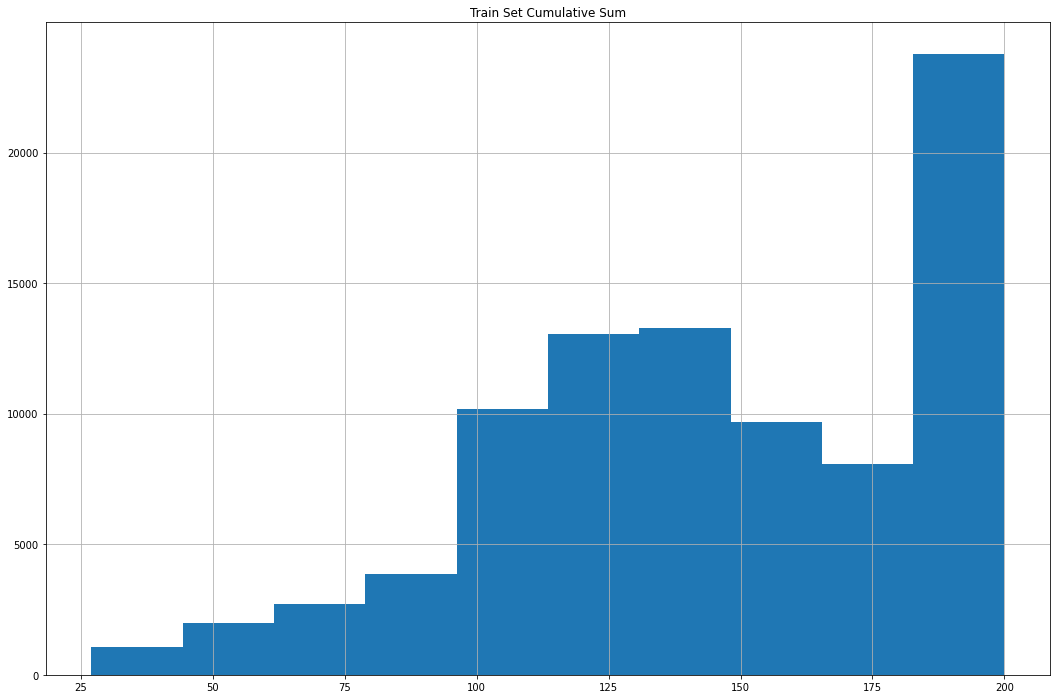

<Figure size 432x288 with 0 Axes>

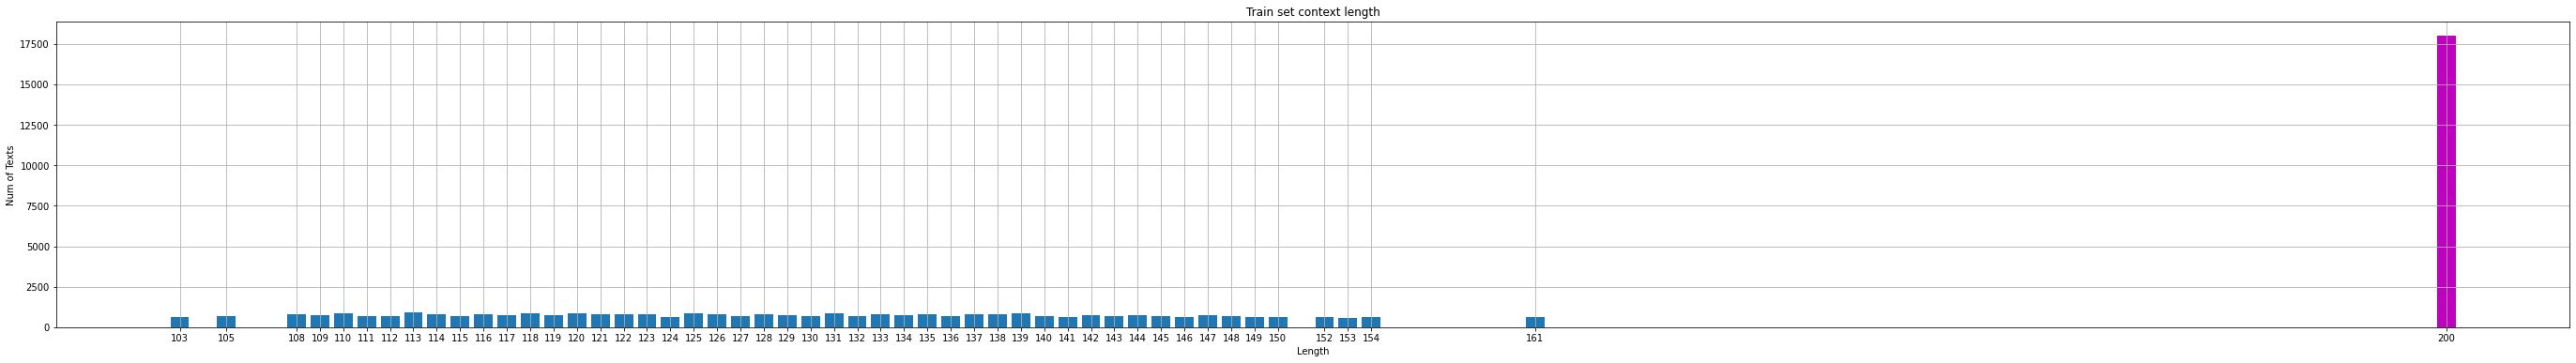


Answerable TRAIN questions for MaxLen 200: 2.65
200


<Figure size 432x288 with 0 Axes>

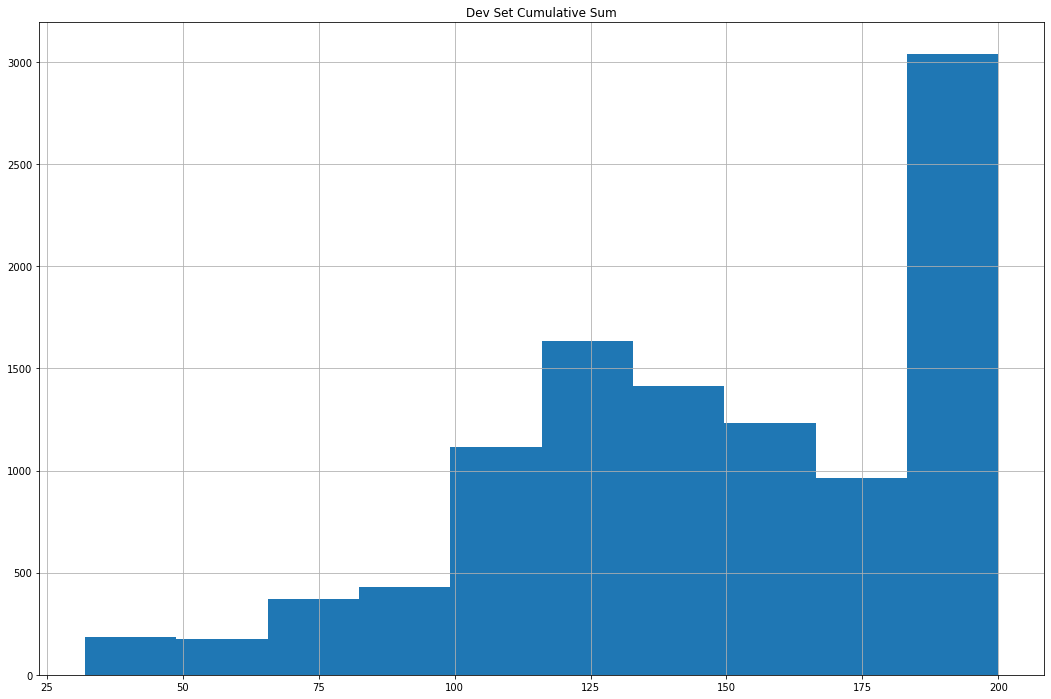

<Figure size 432x288 with 0 Axes>

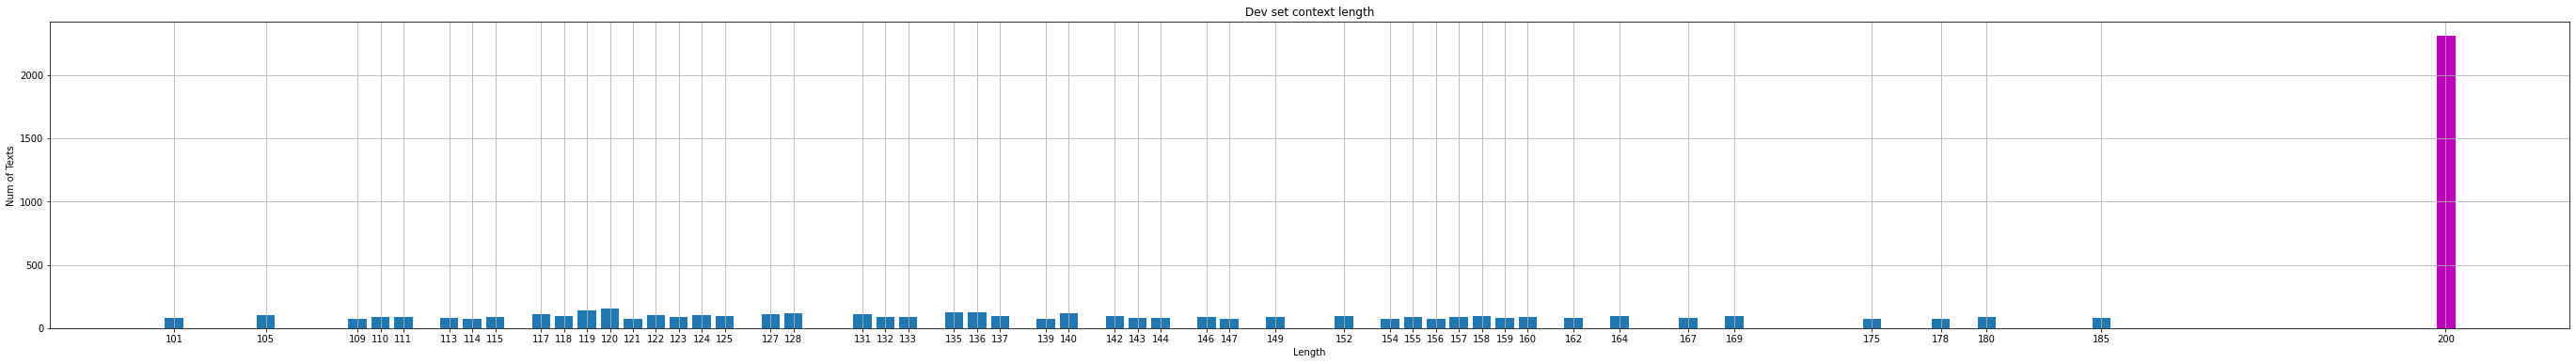


Answerable DEV questions for MaxLen 200: 3.07


In [ ]:
# plot counts of N_max biggest length values of context in the dataset 
lens_to_check=[50,100,150,200,256,300,512,792,3263]
for N_max in lens_to_check:
    lens_to_show=50
    
    lens_train,enc_train = data_stats(train_df, "Train", N_max)
    bar_plotting_lens(lens_train,"Train", lens_to_show, N_max)
    data_vis_unanswerable(train_df, enc_train)
    unanswerable = train_df['start_token_id'].isna().values 
    print(f"\nUnanswerable TRAIN questions for MaxLen {N_max}: { (sum(answerable)/len(lens_train))*100:.2f}")

    lens_dev, enc_dev = data_stats(dev_df, "Dev", N_max) 
    bar_plotting_lens(lens_dev,"Dev", lens_to_show, N_max)
    data_vis_unanswerable(dev_df,enc_dev)
    unanswerable = dev_df['start_token_id'].isna().values 
    print(f"\nUnanswerable DEV questions for MaxLen {N_max}: { (sum(unanswerable)/len(lens_dev))*100:.2f}")

    
# plot cumulative sum and percentage of samples with context under length L
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

enc = tokenizer(list(train_df['context']), truncation=False)
lens_train=[ len(i_id) for i_id in enc["input_ids"] ]
perc_Csum(lens_train, "Train")

enc = tokenizer(list(dev_df['context']), truncation=False)
lens_dev=[ len(i_id) for i_id in enc["input_ids"] ]
perc_Csum(lens_dev, "Dev")

FileLinks(".")

# TODO:

1. Check unanswerable questions by tokens (after tokenization) -> start == model_max_length !!!!!!

In [ ]:
lens = data_stats(train_df, "Train")
sizes = [50,100,150,200,256,300,512, max(lens)+1]
for s in sizes:
    print(f"Max Len:{s}\nUnanswerable Qs: {check_unanswerable(train_df, s):.2f}% \n\n")

In [ ]:
for pos in range(100):
    print(len(train_df["context"][pos]),train_df["answers"][pos][0]["answer_start"], train_df["answers"][pos][0]["answer_start"]+len(train_df["answers"][0][0]["text"]))

## Data Pre-Processing
---

In [ ]:
# clean GPU cache
import gc
import torch
def clean_GPU_cache(print_sum=False):
    if print_sum:  
        print("\nBefore\n")
        print(torch.cuda.memory_summary(device=device, abbreviated=False))
    torch.cuda.memory_summary(device=None, abbreviated=False)
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    if print_sum:  
        print("\n\nAfter\n")
        print(torch.cuda.memory_summary(device=device, abbreviated=False))

def check_gpu():
    clean_GPU_cache()
    print("\n")
    !nvidia-smi
    print("\n")

# clean_GPU_cache()

In [ ]:
# load distilBERT tokenizer & model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.model_max_length = 256

# tokenize - truncate or pad only context if needed 
train_encodings = tokenizer(list(train_df['context']), list(train_df['question']), max_length=tokenizer.model_max_length, truncation="only_first", padding='max_length')
dev_encodings = tokenizer(list(dev_df['context']), list(dev_df['question']), max_length=tokenizer.model_max_length, truncation="only_first", padding='max_length')

# create the train/test encodings
# reference: https://huggingface.co/docs/transformers/tasks/question_answering
# train_encodings = preprocess_function(train_df, tokenizer)
# dev_encodings = preprocess_function(dev_df, tokenizer)

# id to answers dictionary
global id_to_answers
id_to_answers = { id_num:ans for id_num,ans in zip( dev_df["id"].values, dev_df["answers"].values ) }

In [ ]:
# data processing
# add end offset to the answers dictionaries
train_df=add_ans_ind(train_df)
dev_df=add_ans_ind(dev_df)

answer_starts_train=[ ans[0]["answer_start"] for ans in train_df["answers"].values ]
answer_ends_train=[ ans[0]["answer_end"] for ans in train_df["answers"].values ]
train_encodings.update({"start":answer_starts_train, "end":answer_ends_train})

answer_starts=[ ans[0]["answer_start"] for ans in dev_df["answers"].values ]
answer_ends=[ ans[0]["answer_end"] for ans in dev_df["answers"].values ]
dev_encodings.update({"start":answer_starts, "end":answer_ends})

add_token_positions(train_encodings, train_df["context"], answer_starts_train, answer_ends_train)

# create dataaframes with useful information
train_enc_df=pd.DataFrame({ k:train_encodings[k] for k in train_encodings.keys() })
dev_enc_df=pd.DataFrame({ k:dev_encodings[k] for k in dev_encodings.keys() })

# save encodings
# train_df.to_csv(os.path.join(results_path,f"SQuADv1_train_encodings_{tokenizer.model_max_length}.csv"), index=False, header=True)
# dev_df.to_csv(os.path.join(results_path,f"SQuADv1_dev_encodings_{tokenizer.model_max_length}.csv"), index=False, header=True)


In [ ]:
# load encodings df
# train_enc_path=f"/kaggle/input/squadv1-encodings-bert{tokenizer.model_max_length}/SQuADv1_train_encodings_{tokenizer.model_max_length}.csv"
# train_encodings=pd.read_csv(train_enc_path)
# dev_enc_path=f"/kaggle/input/squadv1-encodings-bert{tokenizer.model_max_length}/SQuADv1_dev_encodings_{tokenizer.model_max_length}.csv"
# dev_encodings=pd.read_csv(dev_enc_path)

# # keep half the data due to computational complexity
# train_encodings=train_encodings[:int(train_encodings.shape[0]/4)]
# print(train_encodings.shape[0])

# # converse to dictionaries
# train_encodings={ k:train_encodings[k].values for k in train_encodings.columns  }
# dev_encodings={ k:dev_encodings[k].values for k in dev_encodings.columns  }

In [ ]:
class BERTinput(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, ind):
        return {key: torch.tensor(value[ind]) for key,value in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


In [ ]:
from tqdm import tqdm

clean_GPU_cache()
batch_size=32

# build datasets for both our training and validation sets
train_dataset = BERTinput(train_encodings)
dev_dataset = BERTinput(dev_encodings)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# initialize validation set data loader
val_loader = DataLoader(dev_dataset, batch_size=batch_size)

# with open(f'/kaggle/..../train_loader_{tokenizer.model_max_length}.pickle', 'wb') as handle:
#     pickle.dump(train_loader, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Training
---

In [ ]:
# model training

# setup GPU/CPU
check_gpu()

pretrained = 0
if pretrained==0:
    model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
    model.to(device)    
    model_name = "DistilBertSQuADv1"
else:
    model_name = "DistilBertSQuADv1Pretrained"


model.train()
tot_eps = 5
# initialize adam optimizer with weight decay (reduces chance of overfitting)
lr = 5e-5
# optim = torch.optim.Adam(model.parameters(), lr=9e-6)
weight_decay = 0.999
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

logfile, datetime_info, model_logfile_dir_path, logfilefullpath = get_file_ptr(results_path,model_name)
log_model_bert(logfile,datetime_info,model_name,optimizer,batch_size,tokenizer.model_max_length,len(train_dataset),len(dev_dataset))

overall_train_loss = []
overall_dev_loss = []
max_f1_mean = -99
em_scores = []
f1_scores = []
ep = 0
loss_dev = []
for epoch in range(tot_eps):
    epoch_loss_train = 0
    epoch_acc = 0
    epoch_acc_dev = 0
    epoch_loss_dev = 0
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        
        # initialize calculated gradients (from prev step)
        optimizer.zero_grad()
        
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        # train model on batch and return outputs (including loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optimizer.step()
        
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())
        loop.update(1)
        
        epoch_loss_train += loss.item()
        
    
    ep_loss_train = epoch_loss_train / len(train_loader)
    ep_loss_dev = epoch_loss_dev / len(val_loader)

    # keeping loss for learning curve plots
    overall_train_loss.append(ep_loss_train)

    #     evaluation and EM & F1 scores
    epoch_str = f'\n----------------------- Epoch {epoch+1} / {tot_eps} -----------------------\n' 
    print(epoch_str)
    loss_str = f'Train Loss: {ep_loss_train:.3f}\n'
    print(loss_str)  
    
    tot_preds = total_preds_list(model,dev_dataset,device,dev_df)
    em,f1_mean,f1_max,score_str = evalEMandF1_squad1(dev_df,tot_preds,model_logfile_dir_path)
    em_scores.append(em)
    f1_scores.append(f1_mean)
    
        # save best model
    if f1_mean > max_f1_mean:
        best_model= model
        best_model_name=f"DistilBertSquad1_stateDict_ep{epoch+1}_DevF1{f1_mean:.3f}.dict"
        best_model_path = os.path.join(model_logfile_dir_path,f"DistilBertSquad1_stateDict_ep{epoch+1}_DevF1{f1_mean:.3f}.dict")
        torch.save(best_model.state_dict(), best_model_path)
        
        max_f1_mean = f1_mean
        ep = epoch
    
    # write to logfile
    logfile.write("\n"+epoch_str+loss_str)
    logfile.write("\n"+score_str+"\n\n")
    
    
# torch.save(model.state_dict(), PATH)
logfile.close()
new_dir_name = f"{model_logfile_dir_path}_ep{ep+1}__DevF1{f1_scores[ep]:.2f}"
os.rename(model_logfile_dir_path,new_dir_name)      
model_logfile_dir_path=new_dir_name

In [ ]:
# display files as links to download
FileLinks(model_logfile_dir_path)

## Evaluation
---

In [ ]:
best_model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
best_model_dict_path= os.path.join(model_logfile_dir_path, best_model_name)

best_model.load_state_dict(torch.load(best_model_dict_path))
# best_model.load_state_dict(torch.load(f"/kaggle/working/results/DistilBertSquad1_stateDict_ep2_DevF151.641.dict"))

best_model.to(device)   
m = best_model.eval()

total_preds = total_preds_list(best_model,dev_dataset,device,dev_df)
em,f1_mean,f1_max,score_str = evalEMandF1_squad1(dev_df,total_preds,model_logfile_dir_path)

FileLinks(".")

## Predictions
---

In [ ]:
results_path = "/kaggle/working/results/predictions" #change it if not run in Kaggle environment
if not os.path.exists(results_path):
    os.makedirs(results_path)

### Question 2 <br> <span style="font-size:3.9mm;">Manually insert questions</span>

In [ ]:
# Load model
model_max_len=256
best_model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
best_model_dict_path= f"/kaggle/input/bert-qna-{model_max_len}-squadv1/DistilBertSquad1_stateDict_ep2_DevF151.847.dict"
best_model.load_state_dict(torch.load(best_model_dict_path))
best_model.to(device)   
m = best_model.eval()

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.model_max_length=model_max_len

# Handmade short context & questions evaluation
text = "I am Theatina, I live in Athens and I believe life is an illusion !!"
print(f"\nText: {text}\n")

question = "What's my name?"
answer=answer_a_question(question, text, tokenizer, best_model)
print(f"Question: {question}\nPredicted answer: {answer}\n")

question = "What do I believe?"
answer=answer_a_question(question, text, tokenizer, best_model)
print(f"Question: {question}\nPredicted answer: {answer}\n")

question = "Where does Theatina live?"
answer=answer_a_question(question, text, tokenizer, best_model)
print(f"Question: {question}\nPredicted answer: {answer}\n")


### Question 3 <br> <span style="font-size:3.9mm;">200 randomly chosen questions from training set</span>

In [ ]:
# Load model
model_max_len=256
best_model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
best_model_dict_path= f"/kaggle/input/bert-qna-{model_max_len}-squadv1/DistilBertSquad1_stateDict_ep2_DevF151.847.dict"
best_model.load_state_dict(torch.load(best_model_dict_path))
best_model.to(device)   
m = best_model.eval()

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.model_max_length=model_max_len

# load training set
squad_train_path = "/kaggle/input/bert-code/bert/train-v1.1.json"
train_df = squad_df(squad_train_path)
all_q_ids=train_df["id"].values

# randomly choose 200 questions
N=200
questions_ids = sample(set(all_q_ids),N)
train_df_200 = train_df[train_df['id'].isin(questions_ids)].reset_index(drop=True)
train_df_200["g_answer"] = [ a[0]["text"] for a in train_df_200["answers"]]
context_list = train_df_200["context"].values
question_list = train_df_200["question"].values
g_answer_list = train_df_200["g_answer"].values

# answer questions and keep predictions for evaluation
total_predictions_list=[]
q_logfile_str=""
em,f1="Yes",0.0
mean_em, mean_f1=0.0,0.0
for num,(c,q,g_answer) in enumerate(zip(context_list,question_list,g_answer_list)):
    answer=answer_a_question(q, c, tokenizer, best_model)
    total_predictions_list+=answer
    
    f1 = compute_f1(g_answer, answer)
    mean_f1+=f1
        
    em_val = compute_exact_match(g_answer, answer)
    mean_em+=em_val
    
    em = "Yes" if em_val else "No"
    q_logfile_str+=f"\nQ{num+1}. {q}\nPredicted answer: {answer}\nGolder answer: {g_answer}\n(F1: {f1*100:.2f}%  |  EM: {em})\n"
    
mean_f1=mean_f1/N
mean_em=mean_em/N
score_str=f"\nMean F1: {mean_f1*100:.2f}%  |  Mean EM: {mean_em*100:.2f}%\n"

logfile=os.path.join(results_path, "Train_200_questions.txt")    
with open(logfile, "w", encoding="utf-8") as writer:
    writer.write(score_str+"\n")
    writer.write(q_logfile_str)
    
q_logfile_str_out=score_str+q_logfile_str
print(q_logfile_str_out)
    
FileLinks(".")

## 📚 References

[SQuAD: 100,000+ Questions for Machine Comprehension of Tex](https://nlp.stanford.edu/pubs/rajpurkar2016squad.pdf)<br>
[Evaluating QA: Metrics, Predictions, and the Null Response](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/2020-06-09-Evaluating_BERT_on_SQuAD.ipynb)<br>
[How-to Fine-Tune a Q&A Transformer](https://towardsdatascience.com/how-to-fine-tune-a-q-a-transformer-86f91ec92997)<br>
[NLP - Document Retrieval for Question Answering](https://www.kaggle.com/code/leomauro/nlp-document-retrieval-for-question-answering)<br>
[DistilBERT base model (uncased) ](https://huggingface.co/distilbert-base-uncased)<br>
[SQuAD v1.1](https://datarepository.wolframcloud.com/resources/SQuAD-v1.1)<br>
[kamalkraj/BERT-SQuAD ](https://github.com/kamalkraj/BERT-SQuAD)<br>
[Question answering](https://huggingface.co/docs/transformers/tasks/question_answering)<br>




